### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Tanzid Sultan`

**Student ID:**     `1430660`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [44]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

In [27]:
import numpy as np

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])


In [28]:
import cv2
from matplotlib import pyplot as plt

filtered image shape: (256, 256)


Text(0.5, 1.0, 'filtered image')

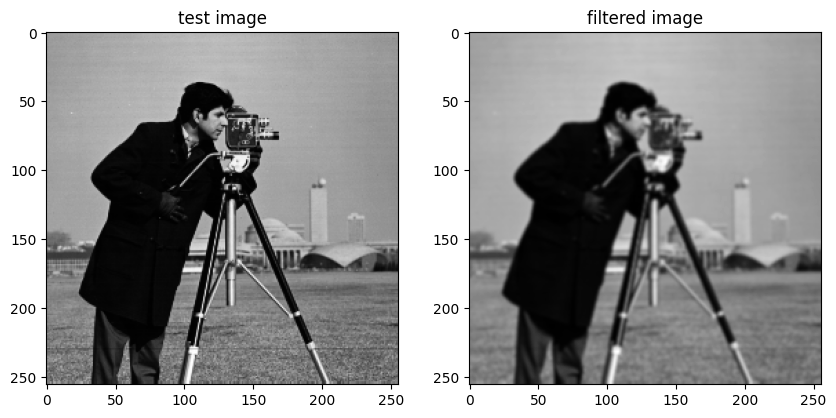

In [29]:
# read in test image as grayscale
test_img = cv2.imread('./cameraman.png', cv2.IMREAD_GRAYSCALE)

# apply filter
filtered_img = cv2.filter2D(test_img, -1, kernel)

print(f"filtered image shape: {filtered_img.shape}")

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.imshow(test_img, cmap='gray')
plt.title('test image')

plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray')
plt.title('filtered image')



In [30]:
# function for filtereing an image
def filter(I, kernel):
    return cv2.filter2D(I, -1, kernel)


# function for downsampling an image by a factor of 1/2
def downsample(I):
    # keep every other row/column
    D = I[1::2, 1::2]
    return D

# function for upsampling an image by factor of 2
def upsample(I):
    height = I.shape[0] 
    width =  I.shape[1]
    U = np.zeros(shape=(2*height, 2*width))
    # upsampled image will contain zeros on every other row/column
    for i in range(height):
        for j in range(width):
            U[2*i, 2*j] = I[i,j]

    return U        
    
# function for creating a laplace pyramid for an input image
def createLaplacePyramid(I, g, n):
    # list of pyramid images
    L_pyramid = []
    # iterate over pyramid image levels 
    for i in range(n):
        if i < (n-1):
            # filter the image with gaussian kernel
            F = filter(I, g)
            # downsample the filtered image
            D = downsample(F)
            # upsample the image then filter by the gaussian kernel and increase brightness by factor of 4 to compensate for upsampling
            U = filter(upsample(D), 4*g)
            # compute difference image for this level
            L = I - U
            L_pyramid.append(L)
            # use downsampled image as input for next level
            I = D
        else:
            # the last level will not be processed any further
            L_pyramid.append(I)    

    return L_pyramid        

# function for reconstructing image from laplace pyramid
def reconstructFromPyramid(L, g):
    n = len(L)
    I = L[-1]
    for i in range(n-2, -1,-1):
        # upsample the pyramid image and apply filter compensated for brightness
        U = filter(upsample(I), 4*g)
        I = U + L[i]

    return I


In [93]:
def plotPyramid(img, pyramid):
    plt.figure(figsize=(12,6))
    n = len(pyramid)
    plt.subplot(1,n+1,1)
    plt.imshow(img, cmap='gray')
    plt.title('test image')
    for i in range(n):
        plt.subplot(1,n+1,i+2)
        plt.imshow(pyramid[i], cmap='gray')
        plt.title('L'+ str(i))


def plotPyramidHistograms(img, pyramid):
    plt.figure(figsize=(18,2))
    n = len(pyramid)
    plt.subplot(1,n+1,1)
    plt.hist(np.ravel(img), bins=50)
    plt.title('test image histogram')
    for i in range(n):
        plt.subplot(1,n+1,i+2)
        plt.hist(np.ravel(pyramid[i]), bins=50, range=[6.5, 12.5])
        plt.title('L'+ str(i))


Text(0.5, 1.0, 'upsampled+filtered')

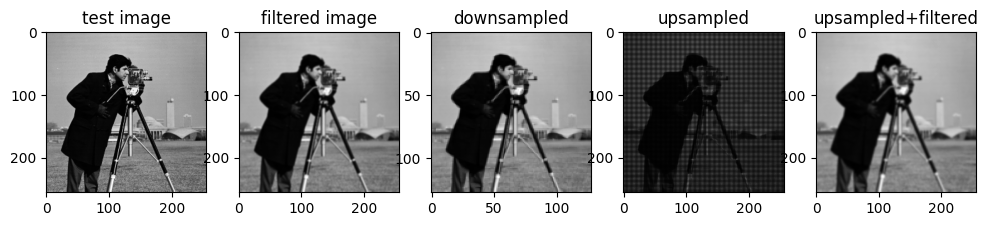

In [74]:
d1 = downsample(filter(test_img, kernel))
u1 = upsample(d1)
f1 = filter(u1, 4*kernel)

plt.figure(figsize=(12,6))

plt.subplot(1,5,1)
plt.imshow(test_img, cmap='gray')
plt.title('test image')

plt.subplot(1,5,2)
plt.imshow(filtered_img, cmap='gray')
plt.title('filtered image')

plt.subplot(1,5,3)
plt.imshow(d1, cmap='gray')
plt.title('downsampled')

plt.subplot(1,5,4)
plt.imshow(u1, cmap='gray')
plt.title('upsampled')

plt.subplot(1,5,5)
plt.imshow(f1, cmap='gray')
plt.title('upsampled+filtered')

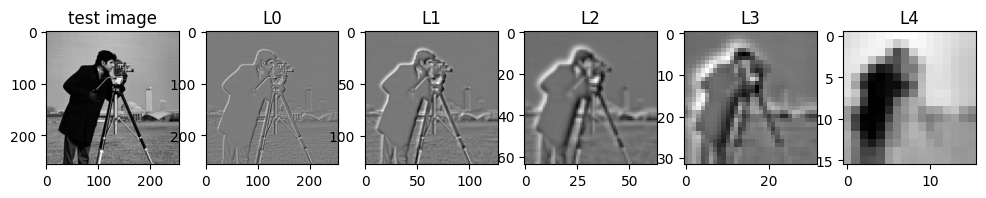

In [134]:
# compute laplace pyramid with 7 levels for the test image
L_pyramid = createLaplacePyramid(test_img, kernel, 5)
plotPyramid(test_img, L_pyramid)

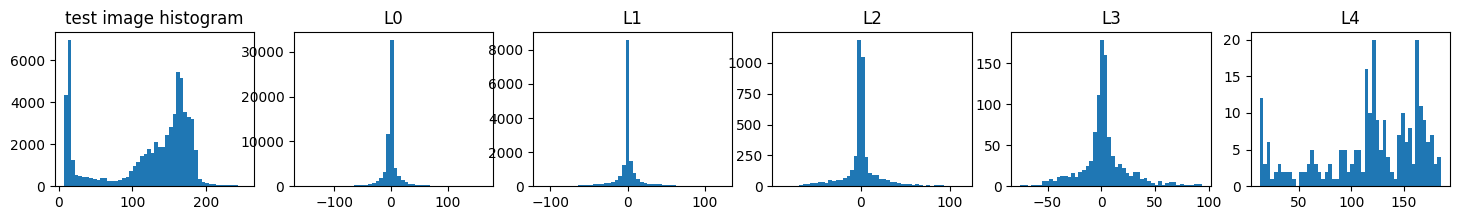

In [135]:
plotPyramidHistograms(test_img, L_pyramid)

Perfect reconstruction: True


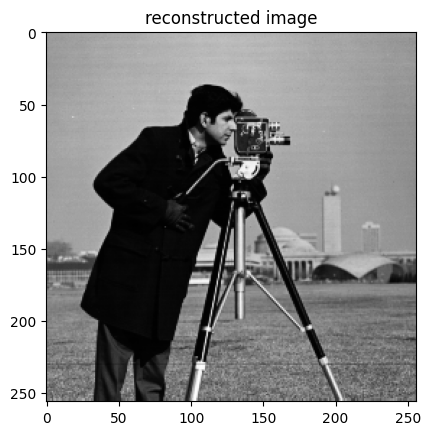

In [34]:
# reconstruct original image from pyramid
rec_img = reconstructFromPyramid(L_pyramid, kernel)

plt.imshow(rec_img, cmap='gray')
plt.title('reconstructed image')

print(f"Perfect reconstruction: {np.array_equal(test_img, rec_img)}")

### 2. Quantization and compression

In [180]:
# function for quantizing image into specified number of bits
def quantize(I, b):

    assert (b >= 1) and (b <= 7), print("Invalid input. 'b' must be in the range [1,7]")

    # number of bins
    nbin = 2**b
    # number of pixels in image
    npix = np.size(I)
    # number of pixels per bin
    if(npix < nbin):
        nbin = npix
    npix_bin = npix // nbin  

    
    # flatten image array and sort pixels in increasing order
    I_flat = np.ravel(I)
    I_flat = np.sort(I_flat)

    # create equal-frequency bins of pixels
    bins = []
    for i in range(nbin):
        lo = i*npix_bin
        hi = min((i+1)*npix_bin, npix) 
        bins.append(I_flat[lo:hi])

    # find edges
    bin_range = []
    #print(bins[0])
    bin_edge = [min(bins[0])-0.01]
    for b in bins:
        bin_edge.append(max(b))
        bin_range.append((min(b), max(b)))

    # place pixels in bins
    I_bin = np.digitize(I, bin_edge, True)-1

    # mean pixel values in bins
    bin_mean = [np.mean(b) for b in bins]
  
    # quantize the image, i.e. replace each pixel value with the mean value of the bin it belongs to
    I_quantized = np.zeros(shape=I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            I_quantized[i,j] = bin_mean[I_bin[i,j]]

    return I_quantized

In [37]:
def plotQuantized(img):
    plt.figure(figsize=(20,8))
    plt.subplot(1,8,1)
    plt.imshow(img, cmap='gray')
    plt.title('test image')

    for i in range(1,8):
        Q = quantize(img, i)
        plt.subplot(1,8,i+1)
        plt.imshow(Q, cmap='gray')
        plt.title('Quantized, b = '+ str(i))

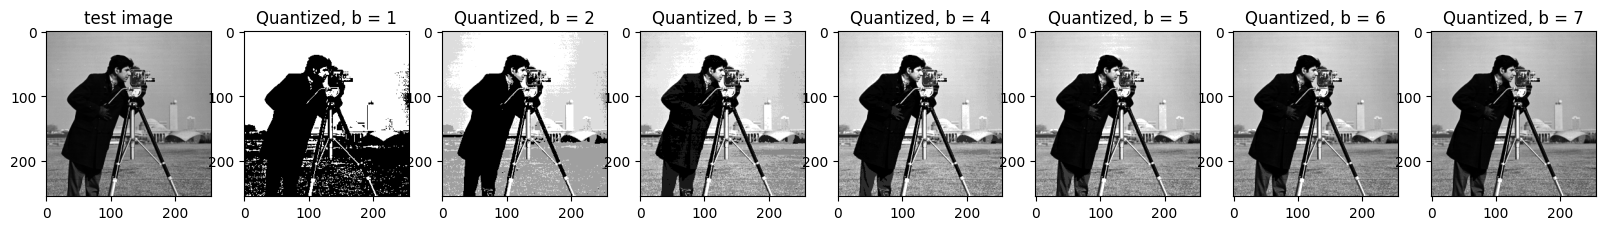

In [38]:
# quntize the test image
plotQuantized(test_img)

In [182]:
# function for creating a laplace pyramid for an input image with quantization
def createLaplacePyramidQuantized(I, g, n, b):
    # list of pyramid images
    L_pyramid = []
    # iterate over pyramid image levels 
    for i in range(n):
        if i < (n-1):
            # filter the image with gaussian kernel
            F = filter(I, g)
            # downsample the filtered image
            D = downsample(F)
            # upsample the image then filter by the gaussian kernel and increase brightness by factor of 4 to compensate for upsampling
            U = filter(upsample(D), 4*g)
            # compute difference image for this level
            L = I - U
            # quantize the difference image
            if(b[i] < 8):
                L = quantize(L, b[i])
            L_pyramid.append(L)
            # use downsampled image as input for next level
            I = D
        else:
            # the last level will not be processed any further
            L_pyramid.append(I)    

    return L_pyramid     

# function for creating a compressed image using the quanticed laplacian pyramid
def compress(img, n, b):
    # generate laplacian pyramid
    L = createLaplacePyramidQuantized(img, kernel, n, b)

    # reconstruct the image from the pyramid
    rec_img = reconstructFromPyramid(L, kernel)

    # compression rate
    bits_image = 8 * 256 * 256
    bits_pyramid = 0
    for i in range(n-1):
        bits_pyramid += b[i] * (256 / pow(2,i)) * (256 / pow(2,i))
    bits_pyramid += 8 * (256 / pow(2,n-1)) * (256 / pow(2,n-1))
    compression = bits_pyramid / bits_image

    return (rec_img, compression)



Text(0.5, 1.0, 'compressed image, compression = 0.3887939453125')

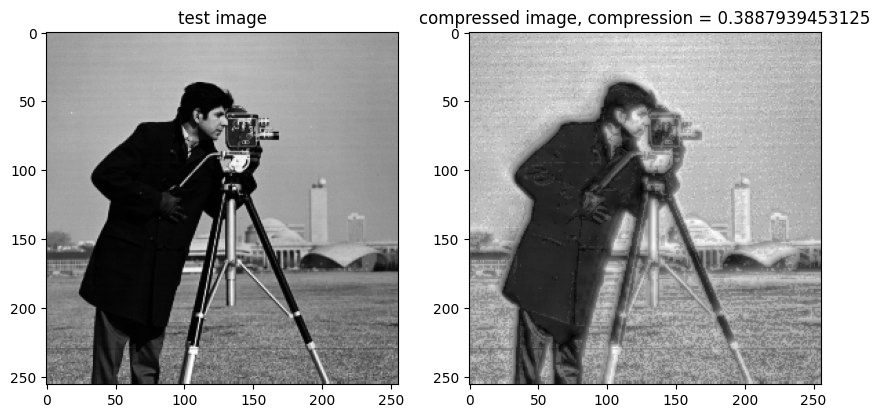

In [183]:
b = [2,3,4,5,6,7,8]
compressed_img, compression = compress(test_img, 7, b)

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.imshow(test_img, cmap='gray')
plt.title('test image')

plt.subplot(1,2,2)
plt.imshow(compressed_img, cmap='gray')
plt.title('compressed image, compression = ' + str(compression))


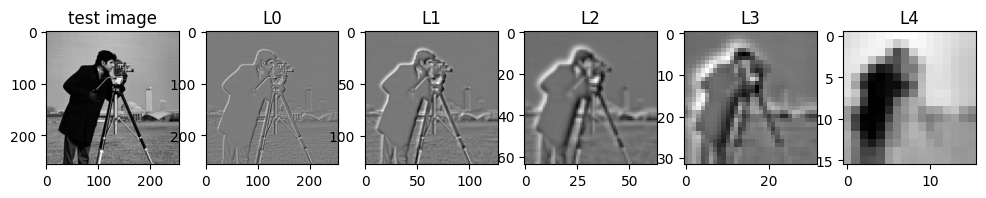

In [136]:
# laplace pyramid with 5 levels without quantization 
L_pyramid = createLaplacePyramid(test_img, kernel, 5)
plotPyramid(test_img, L_pyramid)

Text(0.5, 1.0, 'reconstructed image')

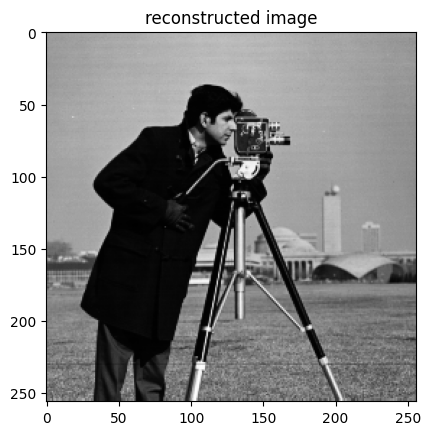

In [97]:
# reconstruct original image from pyramid
rec_img = reconstructFromPyramid(L_pyramid, kernel)

plt.imshow(rec_img, cmap='gray')
plt.title('reconstructed image')


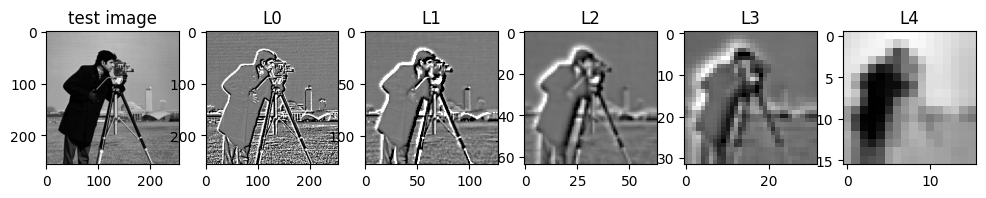

In [145]:
# laplace pyramid with 5 levels with quantization 
b = [3,4,6,7,7]
L_pyramid_q = createLaplacePyramidQuantized(test_img, kernel, 5, b)
plotPyramid(test_img, L_pyramid_q)

Text(0.5, 1.0, 'reconstructed quantized image')

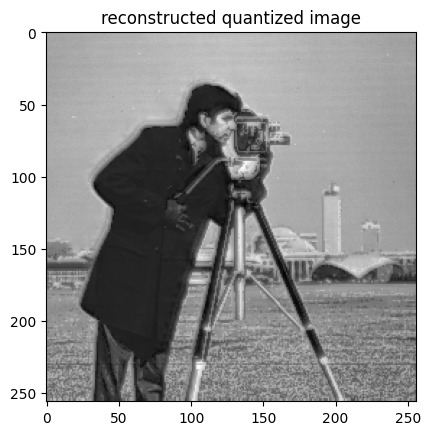

In [146]:
# reconstruct original image from pyramid
rec_img_q = reconstructFromPyramid(L_pyramid_q, kernel)

plt.imshow(rec_img_q, cmap='gray')
plt.title('reconstructed quantized image')

[-154.6875   -147.875    -145.546875 ...   -2.5625     -2.5625
   -2.5625  ]
[-110.4375  -106.9375   -96.90625 ...   -9.25      -9.25      -9.25   ]
[-88.75     -80.5      -78.875    -78.234375 -77.75     -75.546875
 -75.       -72.703125 -72.578125 -72.3125   -70.78125  -67.75
 -67.5      -67.25     -67.25     -67.0625   -66.25     -65.625
 -65.609375 -65.0625   -64.5      -64.5      -63.875    -63.1875
 -63.0625   -63.       -62.4375   -62.375    -62.25     -62.0625
 -61.9375   -61.875    -61.75     -61.671875 -61.5      -61.5
 -61.5      -61.25     -60.4375   -60.25     -60.25     -60.
 -59.75     -59.546875 -59.       -58.875    -58.6875   -58.453125
 -58.25     -58.25     -58.203125 -57.875    -57.5      -57.5
 -57.4375   -57.4375   -57.       -56.875    -56.609375 -56.25
 -56.1875   -55.875    -55.84375  -55.8125   -55.109375 -54.9375
 -54.9375   -54.5      -54.3125   -54.171875 -53.8125   -53.5625
 -53.375    -53.359375 -53.265625 -53.       -53.       -53.
 -52.9375   -52.67187

ValueError: min() arg is an empty sequence

### 3. Evaluation in the frequency domain

In [118]:
'''
    Code borrowed from workshop 3
'''
# Fast fourier transform of image

def FFT_image(img):
    # Fourier transform
    f = np.fft.fft2(img)
    # Shift the low frequency component to the center
    f = np.fft.fftshift(f)
    
    # Fourier phase and magnitude
    phase = np.angle(f)
    magnitude = np.abs(f)
    # the orginal magnitute is too small, we show log of the value to make it clear
    magnitude_log = np.log(np.abs(f))  

    return (magnitude_log, phase)

def plot_FFT_image_log(img):
    # Fourier transform
    f = np.fft.fft2(img)
    # Shift the low frequency component to the center
    f = np.fft.fftshift(f)
    
    # Fourier phase and magnitude
    phase = np.angle(f)
    magnitude = np.abs(f)
    # the orginal magnitute is too small, we show log of the value to make it clear
    magnitude_log = np.log(np.abs(f))  
    
    #figure size
    plt.subplots(figsize=(7, 7)) 

    # Original image
    plt.subplot(2,2,1)
    plt.imshow(img ,cmap='gray')  
    plt.title('image')
    plt.axis('off')

    # Phase
    plt.subplot(2,2,2)
    plt.imshow(phase ,cmap='gray')  
    plt.title('phase')
    plt.axis('off')
    
    # the orginal magnitude
    plt.subplot(2,2,3)
    plt.imshow(magnitude ,cmap='gray')  
    plt.title('magnitude')
    plt.axis('off')

    # log of the orginal magnitude
    plt.subplot(2,2,4)
    plt.imshow(magnitude_log ,cmap='gray')  
    plt.title('log magnitude')
    plt.axis('off')

    plt.show()

/tmp/ipykernel_278811/382787596.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


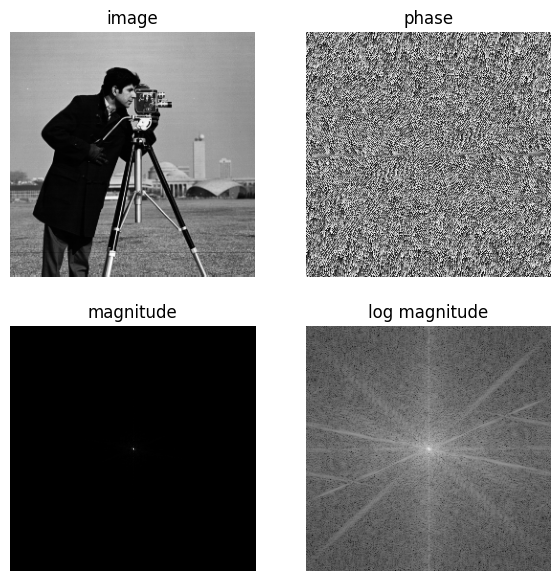

In [108]:
plot_FFT_image_log(test_img)

/tmp/ipykernel_278811/382787596.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


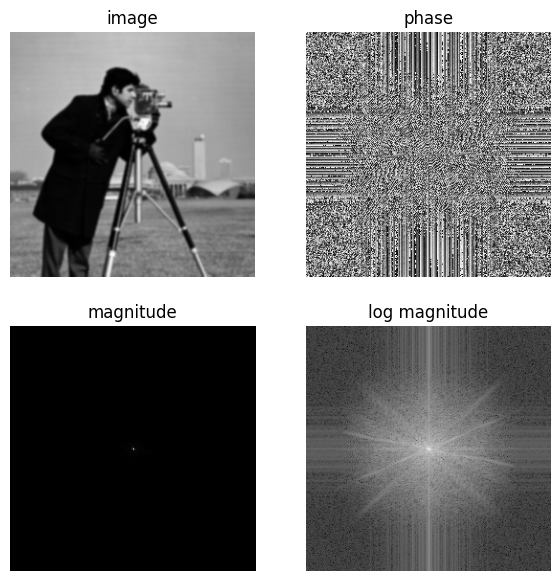

In [109]:
plot_FFT_image_log(filter(test_img, kernel))

In [127]:
def plot_FFT_pyramid(img, pyramid):
    n = len(pyramid)

    magnitude_log, phase = FFT_image(img)
    magnitudes = [magnitude_log]
    phases = [phase]
    
    pix_min, pix_max = (np.min(img), np.max(img))
    mag_min, mag_max = (np.min(magnitude_log), np.max(magnitude_log))
    phase_min, phase_max = (np.min(phase), np.max(phase))

    plt.figure(figsize=(18,12))
    plt.subplot(3,n+1,1)
    plt.imshow(img, cmap='gray', vmin=pix_min, vmax=pix_max)
    plt.title('test image')


    count = 2 
    for i in range(n):
        plt.subplot(3,n+1,count)
        plt.imshow(pyramid[i], cmap='gray', vmin=pix_min, vmax=pix_max)
        plt.title('L'+ str(i))
        magnitude_log, phase = FFT_image(pyramid[i])
        magnitudes.append(magnitude_log)
        phases.append(phase)
        count += 1

    plt.subplot(3,n+1,count)
    plt.imshow(magnitudes[0], cmap='gray', vmin=mag_min, vmax=mag_max)
    count += 1
    for i in range(n):
        plt.subplot(3,n+1,count)
        plt.imshow(magnitudes[i+1], cmap='gray', vmin=mag_min, vmax=mag_max)
        count += 1

    plt.subplot(3,n+1,count)
    plt.imshow(phases[0], cmap='gray', vmin=phase_min, vmax=phase_max)
    count += 1
    for i in range(n):
        plt.subplot(3,n+1,count)
        plt.imshow(phases[i+1], cmap='gray', vmin=phase_min, vmax=phase_max)
        count += 1  

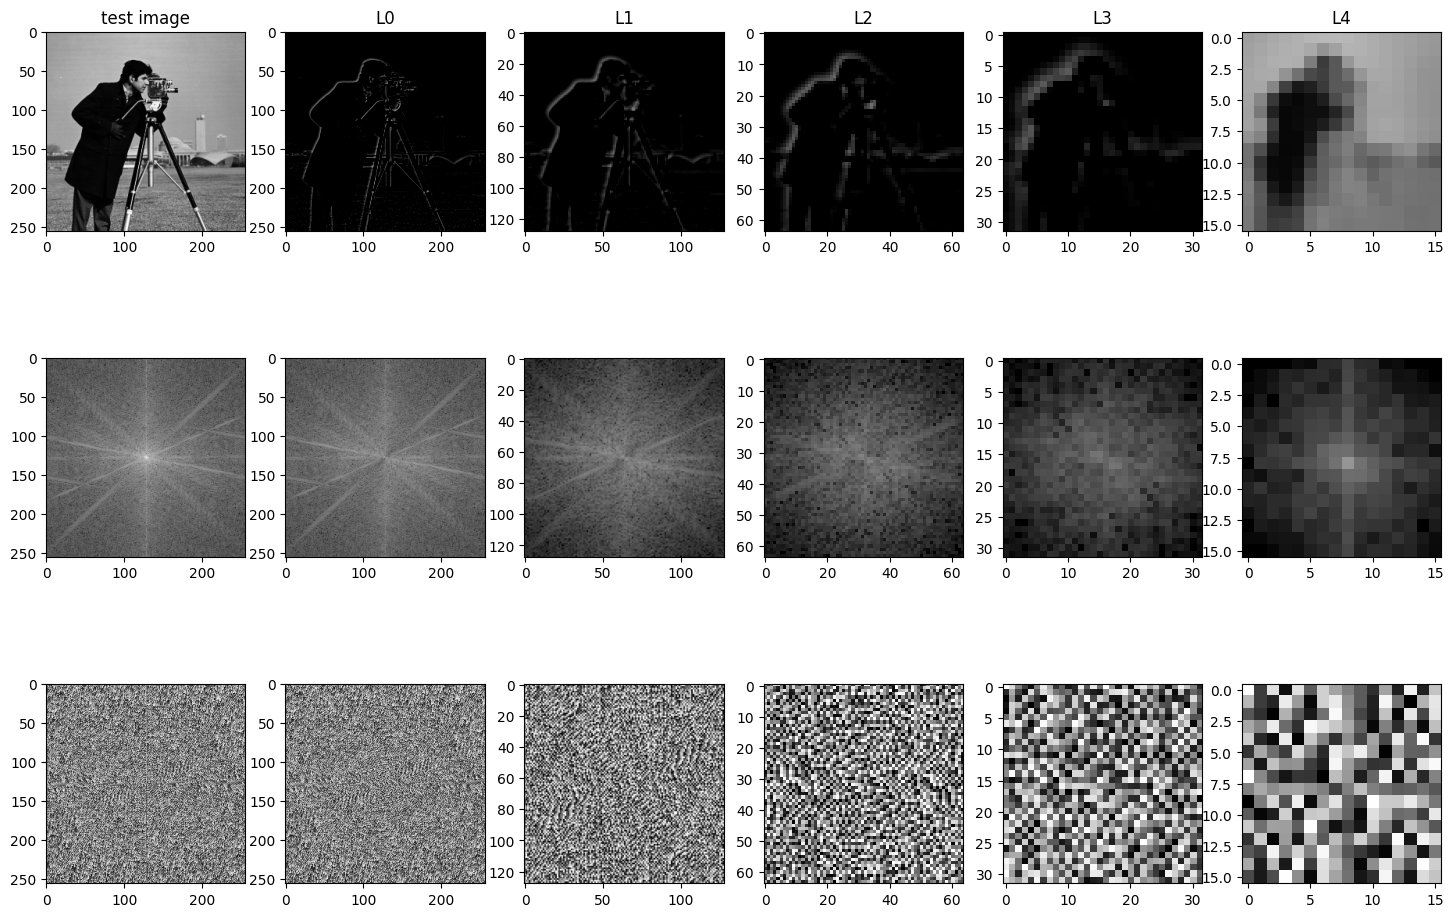

In [128]:
plot_FFT_pyramid(test_img, L_pyramid)

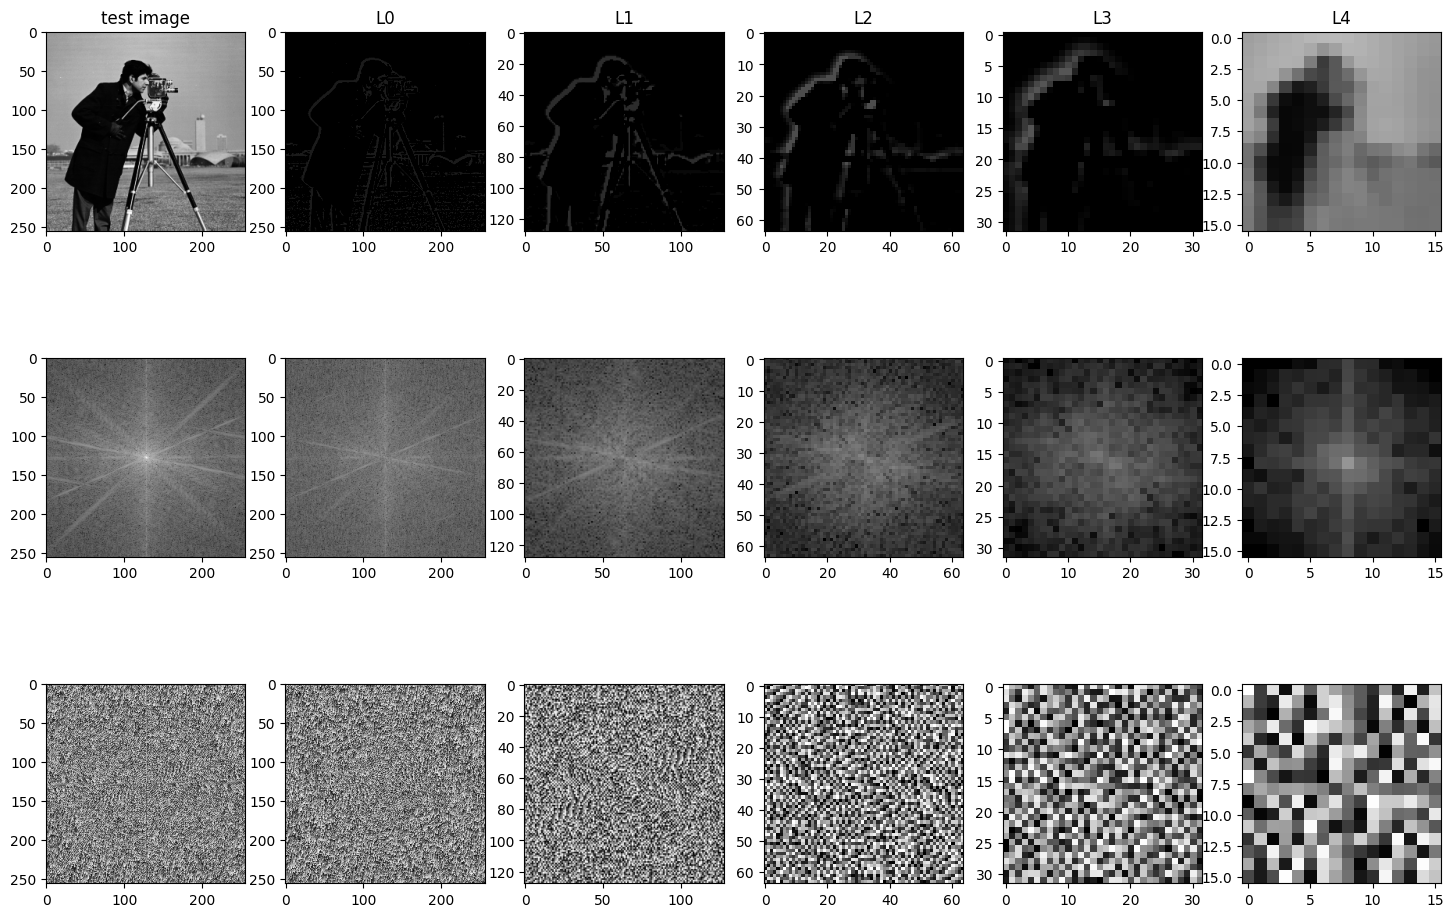

In [133]:
plot_FFT_pyramid(test_img, L_pyramid_q)